# Big Data project
# **San Francisco Crime Classification using pySpark**
### **Author**: Alessio Bonacchi

## Install dependencies and import libraries

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, desc, lit, min, max, split, udf, countDistinct, sum, count
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression,MultilayerPerceptronClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import HashingTF, IDF

import numpy as np
import pandas as pd

import datetime as dt
from pyspark.sql.functions import year,month
from pyspark.sql.functions import to_date

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import seaborn as sns

## Create Spark Session


In [ ]:
# for cluster mode
"""
from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("bda-sfcc").\
        master("spark://spark-master:8088").\
        config("spark.executor.memory", "5120m").\
        getOrCreate()
"""
     


'\nfrom pyspark.sql import SparkSession\n\nspark = SparkSession.        builder.        appName("bda-sfcc").        master("spark://spark-master:8088").        config("spark.executor.memory", "5120m").        getOrCreate()\n'

In [ ]:
# for local mode
spark = SparkSession.builder.getOrCreate()

## Task
The task is to classify San Francisco Crime into 39 pre-defined categories. Each crime is described by a description, its resolution and the district,day,month and year in wich the crime is committed. This is multi-class text classification problem which is solved using several machine learning approach giving pretty good results.

## Data loading

In [ ]:
df_train = spark.read.options(header='true', inferschema='true').csv('/content/drive/MyDrive/train.csv')

In [ ]:
df_train.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

In [ ]:
df_train.printSchema()

root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)



**Data fields**

    - Dates - timestamp of the crime incident
    - Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
    - Descript - detailed description of the crime incident (only in train.csv)
    - DayOfWeek - the day of the week
    - PdDistrict - name of the Police Department District
    - Resolution - how the crime incident was resolved (only in train.csv)
    - Address - the approximate street address of the crime incident 
    - X - Longitude
    - Y - Latitude



In [ ]:
# number of records

print('Total number of records.',df_train.count())

Total number of records. 878049


## Data Preprocessing
These are the steps that I have done in order to preprocess the data:
- **feature generation and removal**: I generate two new features ('month' and 'year') from 'Dates'. Then I am removing features that are not interesting for our purpose: in particular I am removing 'dates', 'Address', 'X' and 'Y'.
- **nulls removal**
- **String processing pipeline**: in the dataset we have string columns, 'descript' and 'resolution'. Their values are processed following this pipeline: 1) tokenization 2) stop words removal 3) Count-Vectorization
- **Transforming to categorical**: like 'DayOfWeek' and 'PdDistrict' we convert this values to numerical indexes.

In [ ]:
# removal of columns that are not useful for multi class classification

df_train = df_train.withColumn('month',month(df_train.Dates))
df_train = df_train.withColumn('year',year(df_train.Dates))
drop_list = ['Dates', 'Address', 'X', 'Y']
df_train = df_train.select([column for column in df_train.columns if column not in drop_list])
df_train.show(5)

+--------------+--------------------+---------+----------+--------------+-----+----+
|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|month|year|
+--------------+--------------------+---------+----------+--------------+-----+----+
|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|    5|2015|
|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|    5|2015|
|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|    5|2015|
| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHERN|          NONE|    5|2015|
| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|      PARK|          NONE|    5|2015|
+--------------+--------------------+---------+----------+--------------+-----+----+
only showing top 5 rows



In [ ]:
# nulls removal

df_train.na.drop()
print('Total number of records.',df_train.count())

Total number of records. 878049


In [ ]:
# string columns pipeline

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="Descript", outputCol="words", pattern="\\W")
# stop words
add_stopwords = ["http","https","amp","rt","t","c","the"] 
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)
# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)


In [ ]:
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label")
days_stringIdx = StringIndexer(inputCol = "DayOfWeek", outputCol = "dayofweek")
res_stringIdx = StringIndexer(inputCol = "Resolution", outputCol = "resolution")
district_stringIdx = StringIndexer(inputCol = "PdDistrict", outputCol = "pddistrict")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx, days_stringIdx, res_stringIdx, district_stringIdx])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df_train)
train_set = pipelineFit.transform(df_train)
drop_list = ['words', 'filtered']
train_set = train_set.select([column for column in train_set.columns if column not in drop_list])
train_set.show(5)

+--------------+--------------------+---------+----------+----------+-----+----+--------------------+-----+
|      Category|            Descript|dayofweek|pddistrict|resolution|month|year|            features|label|
+--------------+--------------------+---------+----------+----------+-----+----+--------------------+-----+
|      WARRANTS|      WARRANT ARREST|      1.0|       2.0|       1.0|    5|2015|(809,[17,32],[1.0...|  7.0|
|OTHER OFFENSES|TRAFFIC VIOLATION...|      1.0|       2.0|       1.0|    5|2015|(809,[11,17,35],[...|  1.0|
|OTHER OFFENSES|TRAFFIC VIOLATION...|      1.0|       2.0|       1.0|    5|2015|(809,[11,17,35],[...|  1.0|
| LARCENY/THEFT|GRAND THEFT FROM ...|      1.0|       2.0|       0.0|    5|2015|(809,[0,2,3,4,6],...|  0.0|
| LARCENY/THEFT|GRAND THEFT FROM ...|      1.0|       8.0|       0.0|    5|2015|(809,[0,2,3,4,6],...|  0.0|
+--------------+--------------------+---------+----------+----------+-----+----+--------------------+-----+
only showing top 5 rows



## Dataset requirements
The requirementsof the project are satisfied. The dataset have more than 800k samples and the features analyzed are 7.

In [ ]:
# number of features
features = train_set.drop('Category').drop('Descript').toPandas().columns.values.tolist()
print('Total number of features: ',len(features))

Total number of features:  7


In [ ]:
# total number of patterns
print('Total number of records.',train_set.count())

Total number of records. 878049


In [ ]:
# number of samples for each category

train_set.groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(39)

+--------------------+------+
|            category| count|
+--------------------+------+
|       LARCENY/THEFT|174900|
|      OTHER OFFENSES|126182|
|        NON-CRIMINAL| 92304|
|             ASSAULT| 76876|
|       DRUG/NARCOTIC| 53971|
|       VEHICLE THEFT| 53781|
|           VANDALISM| 44725|
|            WARRANTS| 42214|
|            BURGLARY| 36755|
|      SUSPICIOUS OCC| 31414|
|      MISSING PERSON| 25989|
|             ROBBERY| 23000|
|               FRAUD| 16679|
|FORGERY/COUNTERFE...| 10609|
|     SECONDARY CODES|  9985|
|         WEAPON LAWS|  8555|
|        PROSTITUTION|  7484|
|            TRESPASS|  7326|
|     STOLEN PROPERTY|  4540|
|SEX OFFENSES FORC...|  4388|
|  DISORDERLY CONDUCT|  4320|
|         DRUNKENNESS|  4280|
|   RECOVERED VEHICLE|  3138|
|          KIDNAPPING|  2341|
|DRIVING UNDER THE...|  2268|
|             RUNAWAY|  1946|
|         LIQUOR LAWS|  1903|
|               ARSON|  1513|
|           LOITERING|  1225|
|        EMBEZZLEMENT|  1166|
|         

## Data Analysis
In this section, the dataset is examined in order to get more in depth knowledge about features, their inter-correlation and how they are linked to the target feature.

### Distribution of crimes
We can see that there is a stron imbalance in the distributions of the different categories.

<Figure size 640x480 with 0 Axes>

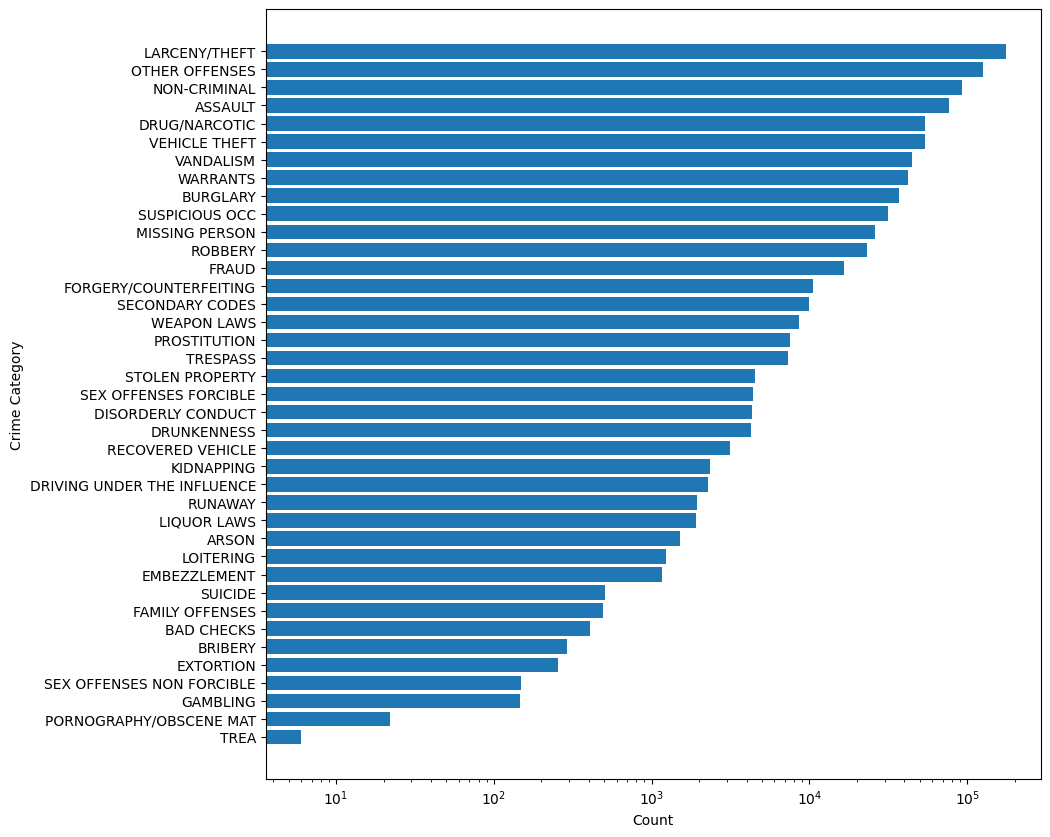

In [ ]:
df_loc = train_set.groupby('category').agg(count('category')).toPandas()
df_loc = df_loc.sort_values('count(category)')

plt.figure()

plt.figure(figsize=(10,10))
plt.barh(df_loc['category'], df_loc['count(category)'], log = True)
plt.ylabel('Crime Category')
plt.xlabel('Count')

plt.show()

### Distribution of crimes among departments
We can see that 'Southern' distric is the most 'criminal', while 'Richmond' seems to be the safest. In the second plot we can also see the different distribution of crimes among districts. This analysis is interesting because it highlights which crime is more probable to happen in a district.

<Figure size 640x480 with 0 Axes>

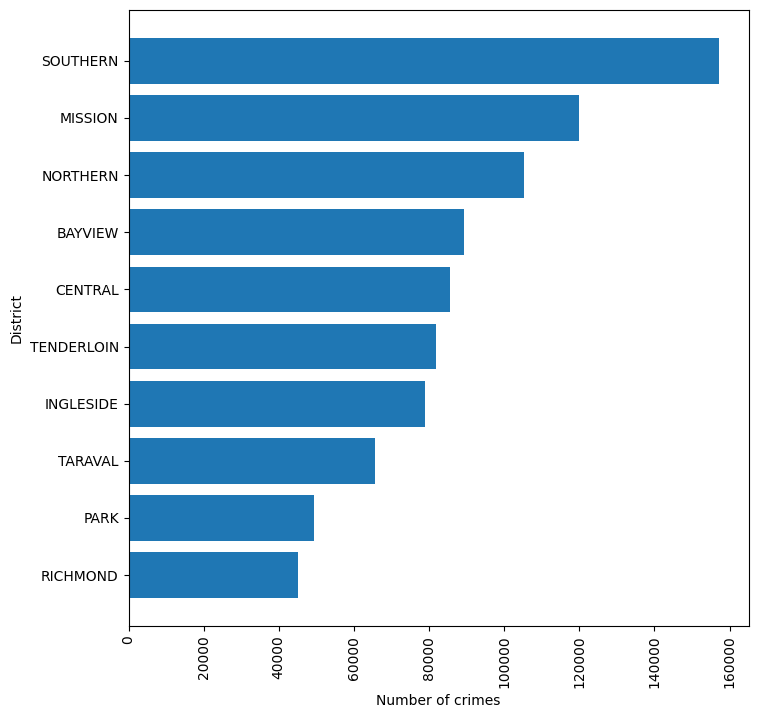

In [ ]:
df_loc = df_train.groupby('pddistrict').agg(count('category')).toPandas()
df_loc = df_loc.sort_values('count(category)').iloc[-20:,:]

plt.figure()

plt.figure(figsize=(8,8))
plt.barh(df_loc['pddistrict'], df_loc['count(category)'])
plt.xlabel('Number of crimes')
plt.ylabel('District')
plt.xticks(rotation='vertical')

plt.show()


In [ ]:
df_copy = df_train.toPandas().copy()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


<Axes: xlabel='PdDistrict'>

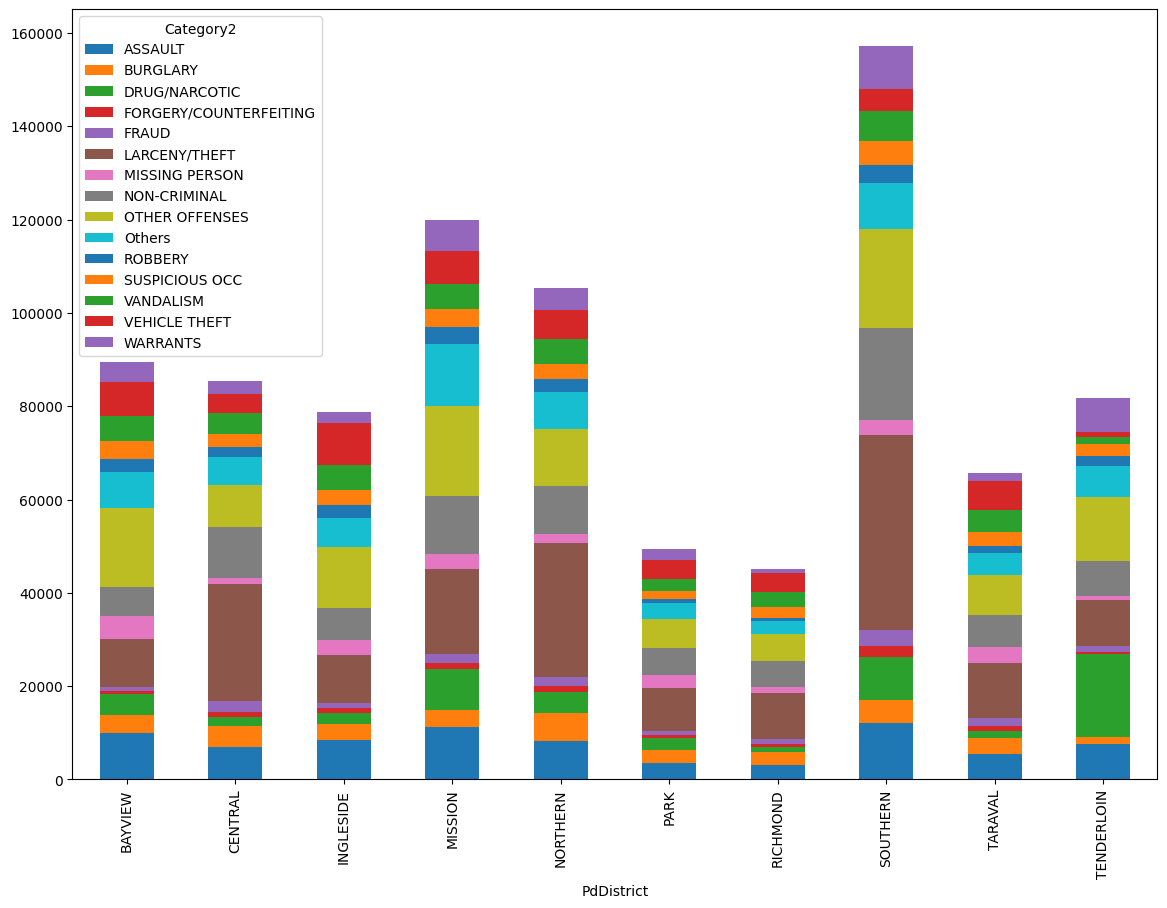

In [ ]:
ct2 = df_copy['Category'].value_counts()[df_copy['Category'].value_counts() > 10000].index
df_copy['Category2']=df_copy['Category'].apply(lambda x: 'Others' if x not in ct2 else x)
df_copy['Category2'].unique()

df_copy.groupby(['PdDistrict','Category2']).\
agg({'Resolution':'count'}).\
pivot_table(index='PdDistrict',columns='Category2')['Resolution'].plot(kind='bar',stacked=True,figsize=(14,10))

### How the crimes have been resolved?
We can see that most of the crimes have not been resolved yet, meaning that the criminal has not been judged.

<Axes: xlabel='Resolution'>

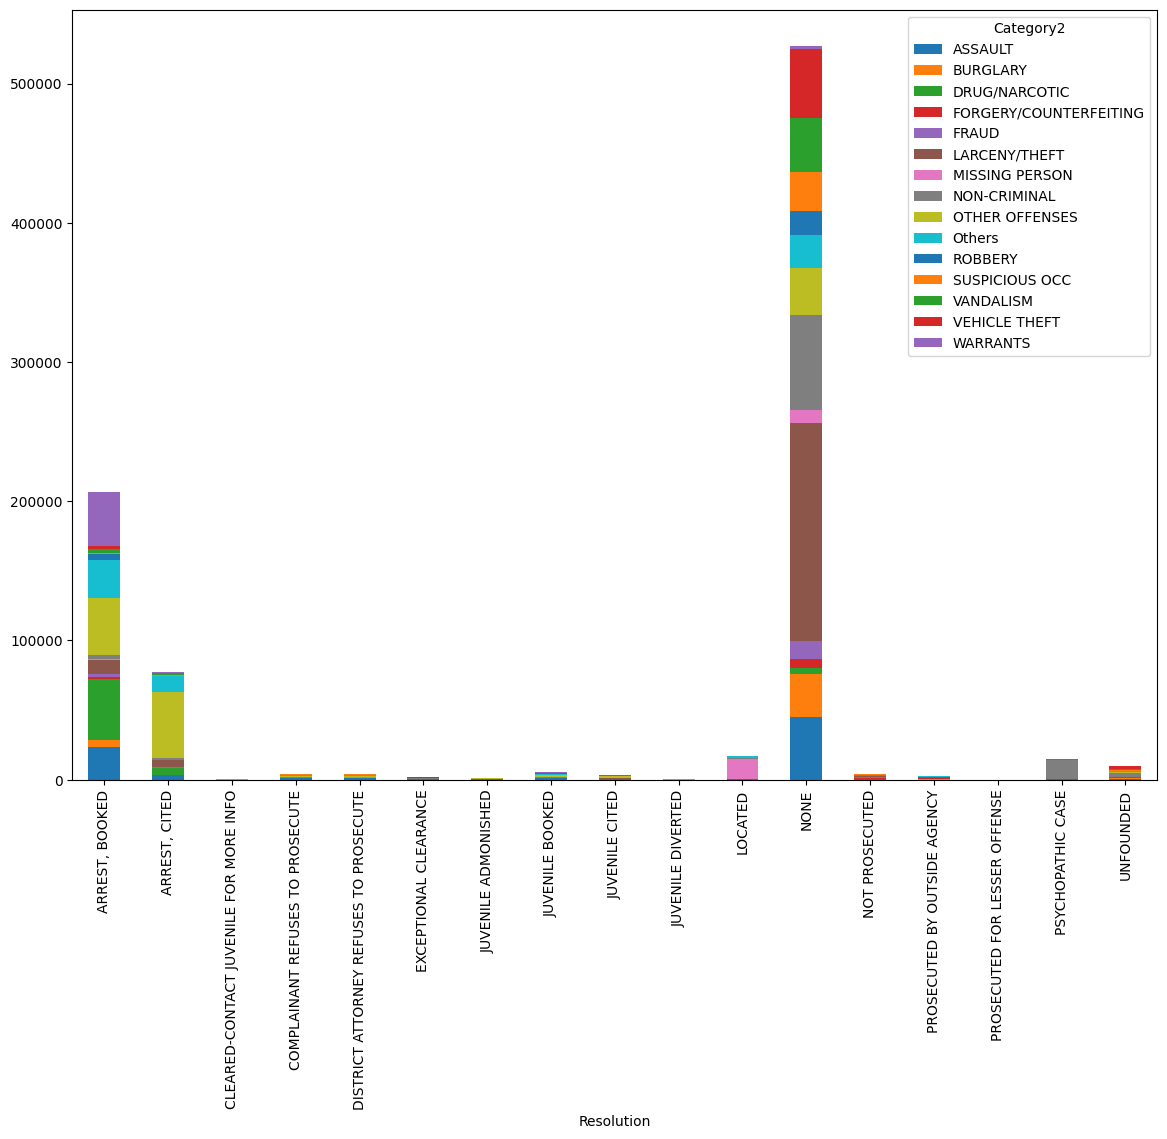

In [ ]:
ct2 = df_copy['Category'].value_counts()[df_copy['Category'].value_counts() > 10000].index
df_copy['Category2']=df_copy['Category'].apply(lambda x: 'Others' if x not in ct2 else x)
df_copy['Category2'].unique()

df_copy.groupby(['Resolution','Category2']).\
agg({'PdDistrict':'count'}).\
pivot_table(index='Resolution',columns='Category2')['PdDistrict'].plot(kind='bar',stacked=True,figsize=(14,10))

### Distribution of crimes among days of the week
We can notice that crimes seems to lower in the weekend, generally. It is interesting to notice that the activities for some of these, intuitively, grows in the weekend, for example 'driving under the influence of drugs' and 'assault'. 

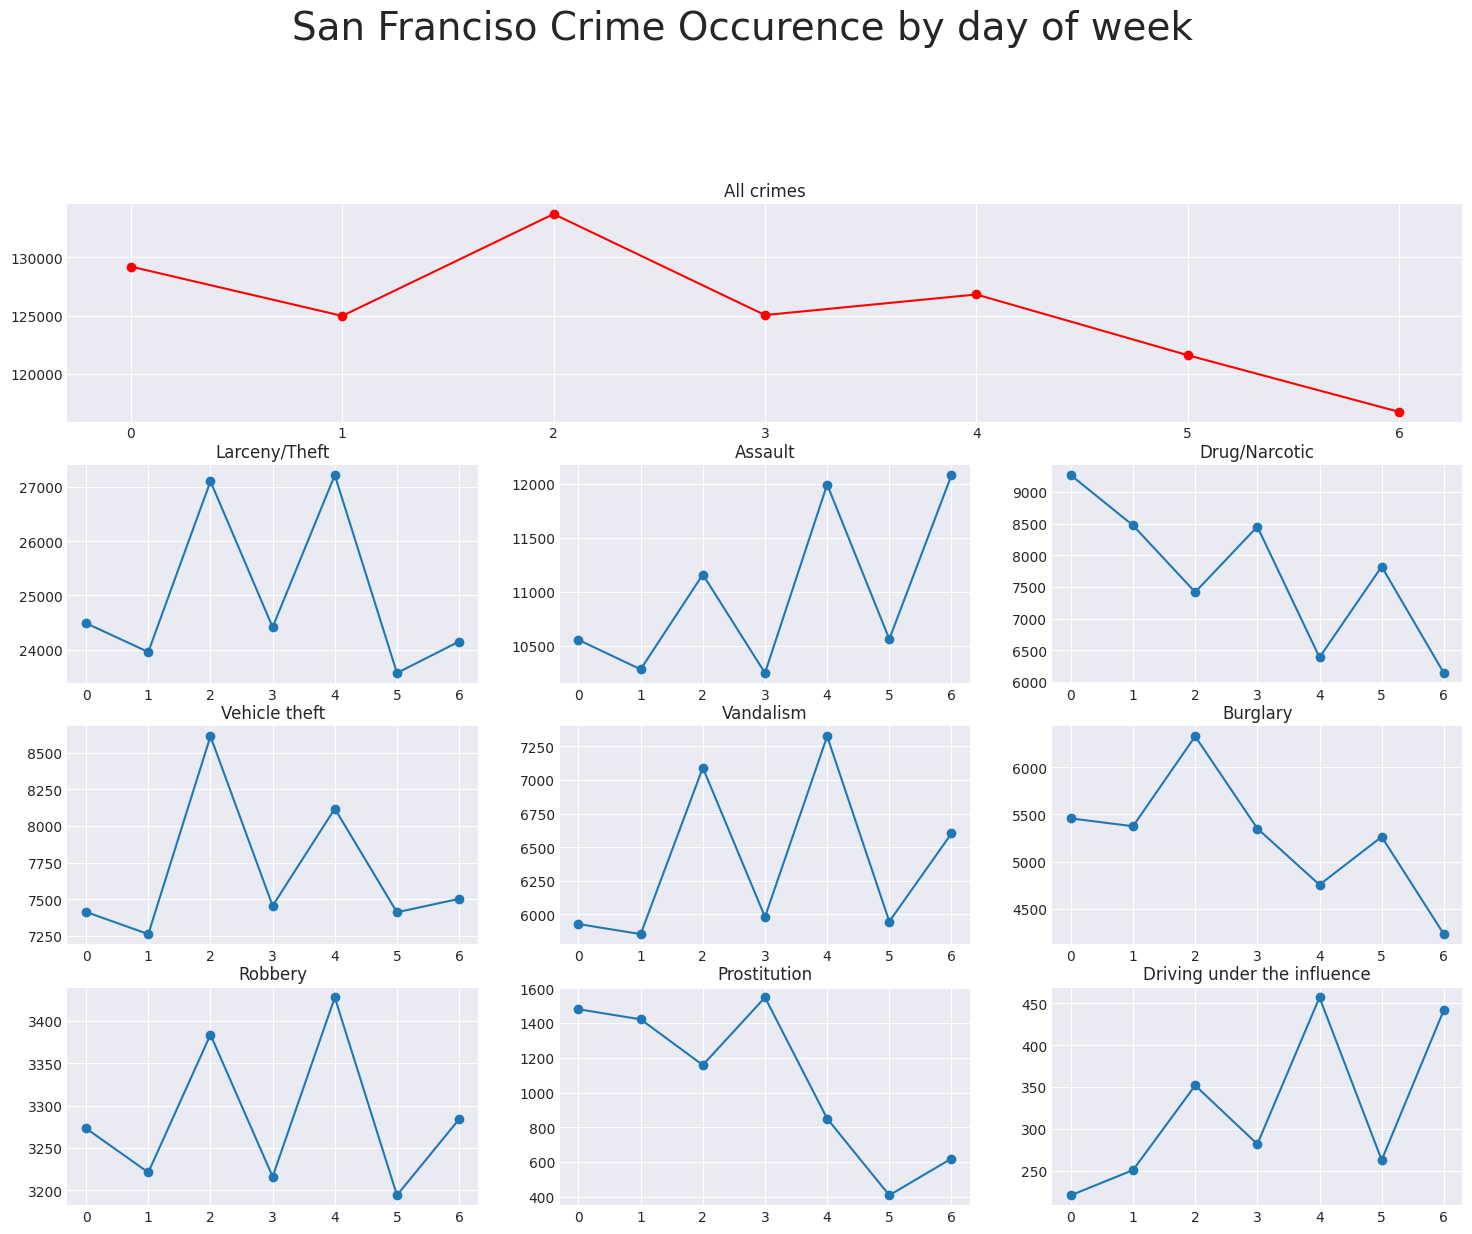

In [ ]:
import pylab
pylab.rcParams['figure.figsize'] = (18.0, 13.0)

larceny = df_train[df_train['Category'] == "LARCENY/THEFT"]
assault = df_train[df_train['Category'] == "ASSAULT"]
drug = df_train[df_train['Category'] == "DRUG/NARCOTIC"]
vehicle = df_train[df_train['Category'] == "VEHICLE THEFT"]
vandalism = df_train[df_train['Category'] == "VANDALISM"]
burglary = df_train[df_train['Category'] == "BURGLARY"]
robbery = df_train[df_train['Category'] == "ROBBERY"]
prostitution = df_train[df_train['Category'] == "PROSTITUTION"]
driving_drunk = df_train[df_train['Category'] == "DRIVING UNDER THE INFLUENCE"]
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


with plt.style.context('seaborn-darkgrid'):
    ax1 = plt.subplot2grid((4,3), (0, 0), colspan=3)
    df = df_train.groupby('dayofweek').agg(count('category')).toPandas()
    df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=cats, ordered=True)
    df.sort_values('dayofweek')


    ax1.plot(df['count(category)'], 'ro-')
    ax1.set_title ('All crimes')
    ax1.xaxis.set_ticks(np.arange(0, 7, 1))
    
    ax2 = plt.subplot2grid((4,3), (1, 0))
    df1 = larceny.groupby('dayofweek').agg(count('category')).toPandas()
    df1['dayofweek'] = pd.Categorical(df1['dayofweek'], categories=cats, ordered=True)
    df1.sort_values('dayofweek')
    ax2.plot(df1['count(category)'], 'o-')
    ax2.set_title ('Larceny/Theft')
    
    ax3 = plt.subplot2grid((4,3), (1, 1))
    df = assault.groupby('dayofweek').agg(count('category')).toPandas()
    df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=cats, ordered=True)
    df.sort_values('dayofweek')
    ax3.plot(df['count(category)'], 'o-')
    ax3.set_title ('Assault')
    
    ax4 = plt.subplot2grid((4,3), (1, 2))
    df = drug.groupby('dayofweek').agg(count('category')).toPandas()
    df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=cats, ordered=True)
    df.sort_values('dayofweek')
    ax4.plot(df['count(category)'], 'o-')
    ax4.set_title ('Drug/Narcotic')
    
    ax5 = plt.subplot2grid((4,3), (2, 0))
    df = vehicle.groupby('dayofweek').agg(count('category')).toPandas()
    df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=cats, ordered=True)
    df.sort_values('dayofweek')
    ax5.plot(df['count(category)'], 'o-')
    ax5.set_title ('Vehicle theft')
    
    ax6 = plt.subplot2grid((4,3), (2, 1))
    df = vandalism.groupby('dayofweek').agg(count('category')).toPandas()
    df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=cats, ordered=True)
    df.sort_values('dayofweek')  
    ax6.plot(df['count(category)'], 'o-')
    ax6.set_title ('Vandalism')
    
    ax7 = plt.subplot2grid((4,3), (2, 2))
    df = burglary.groupby('dayofweek').agg(count('category')).toPandas()
    df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=cats, ordered=True)
    df.sort_values('dayofweek')
    ax7.plot(df['count(category)'], 'o-')
    ax7.set_title ('Burglary')

    ax8 = plt.subplot2grid((4,3), (3, 0))
    df = robbery.groupby('dayofweek').agg(count('category')).toPandas()
    df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=cats, ordered=True)
    df.sort_values('dayofweek')
    ax8.plot(df['count(category)'], 'o-')
    ax8.set_title ('Robbery')
    
    ax9 = plt.subplot2grid((4,3), (3, 1))
    df = prostitution.groupby('dayofweek').agg(count('category')).toPandas()
    df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=cats, ordered=True)
    df.sort_values('dayofweek')
    ax9.plot(df['count(category)'], 'o-')
    ax9.set_title ('Prostitution')
    
    ax10 = plt.subplot2grid((4,3), (3, 2))
    df = driving_drunk.groupby('dayofweek').agg(count('category')).toPandas()
    df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=cats, ordered=True)
    df.sort_values('dayofweek')
    ax10.plot(df['count(category)'], 'o-')
    ax10.set_title ('Driving under the influence')
  
    pylab.gcf().text(0.5, 1.03, 
                    'San Franciso Crime Occurence by day of week',
                     horizontalalignment='center',
                     verticalalignment='top', 
                     fontsize = 28)
plt.show()

### Distribution of crimes among months
We can notice that criminal activities drop in december and this is valid for every crime.

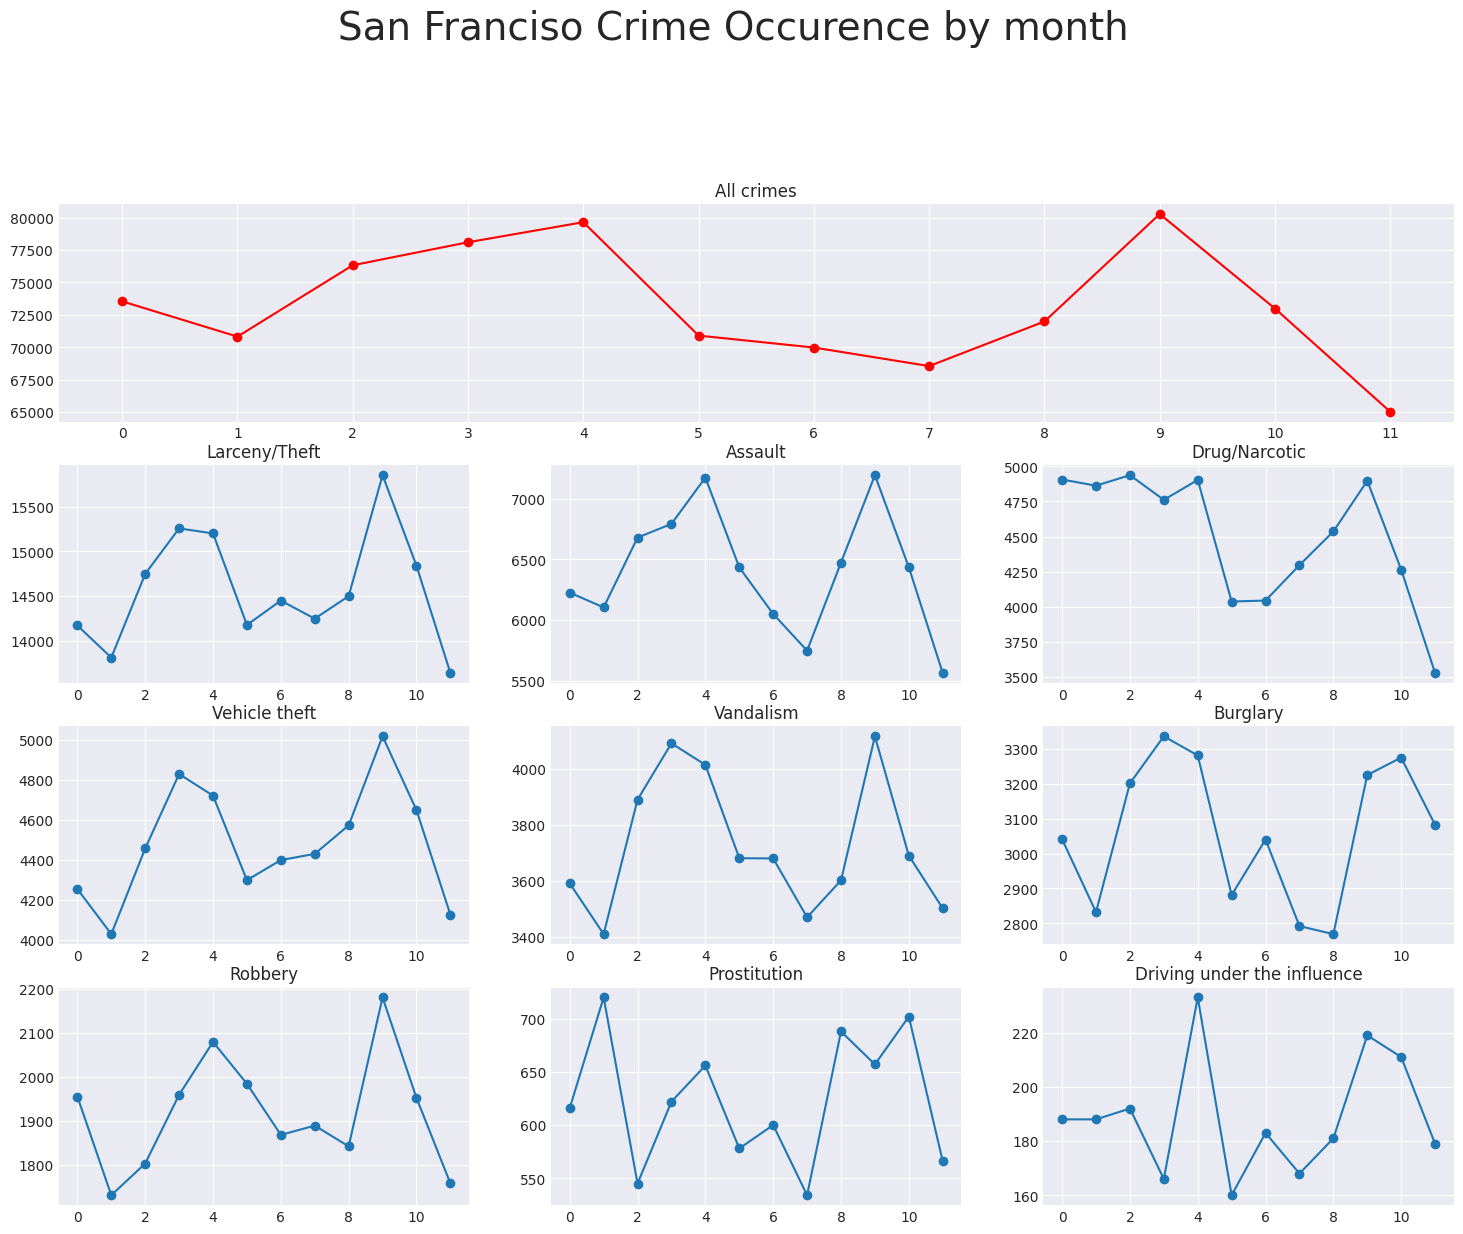

In [ ]:
pylab.rcParams['figure.figsize'] = (18.0, 13.0)

cats = [0,1,2,3,4,5,6,7,8,9,10,11]


with plt.style.context('seaborn-darkgrid'):
    ax1 = plt.subplot2grid((4,3), (0, 0), colspan=3)
    df = df_train.groupby('month').agg(count('category')).toPandas()
    df['month'] = pd.Categorical(df['month'], categories=cats, ordered=True)
    df = df.sort_values('month')
    df = df.reset_index()
    


    ax1.plot(df['count(category)'], 'ro-')
    ax1.set_title ('All crimes')
    ax1.xaxis.set_ticks(np.arange(0, 12, 1))
    
    ax2 = plt.subplot2grid((4,3), (1, 0))
    df1 = larceny.groupby('month').agg(count('category')).toPandas()
    df1['month'] = pd.Categorical(df1['month'], categories=cats, ordered=True)
    df1 = df1.sort_values('month')
    df1 = df1.reset_index().sort_values('month')
    ax2.plot(df1['count(category)'], 'o-')
    ax2.set_title ('Larceny/Theft')
    
    ax3 = plt.subplot2grid((4,3), (1, 1))
    df = assault.groupby('month').agg(count('category')).toPandas()
    df['month'] = pd.Categorical(df['month'], categories=cats, ordered=True)
    df = df.sort_values('month')
    df = df.reset_index()
    ax3.plot(df['count(category)'], 'o-')
    ax3.set_title ('Assault')
    
    ax4 = plt.subplot2grid((4,3), (1, 2))
    df = drug.groupby('month').agg(count('category')).toPandas()
    df['month'] = pd.Categorical(df['month'], categories=cats, ordered=True)
    df = df.sort_values('month')
    df = df.reset_index()
    ax4.plot(df['count(category)'], 'o-')
    ax4.set_title ('Drug/Narcotic')
    
    ax5 = plt.subplot2grid((4,3), (2, 0))
    df = vehicle.groupby('month').agg(count('category')).toPandas()
    df['month'] = pd.Categorical(df['month'], categories=cats, ordered=True)
    df = df.sort_values('month')
    df = df.reset_index()    
    ax5.plot(df['count(category)'], 'o-')
    ax5.set_title ('Vehicle theft')
    
    ax6 = plt.subplot2grid((4,3), (2, 1))
    df = vandalism.groupby('month').agg(count('category')).toPandas()
    df['month'] = pd.Categorical(df['month'], categories=cats, ordered=True)
    df = df.sort_values('month')
    df = df.reset_index()     
    ax6.plot(df['count(category)'], 'o-')
    ax6.set_title ('Vandalism')
    
    ax7 = plt.subplot2grid((4,3), (2, 2))
    df = burglary.groupby('month').agg(count('category')).toPandas()
    df['month'] = pd.Categorical(df['month'], categories=cats, ordered=True)
    df = df.sort_values('month')
    df = df.reset_index()    
    ax7.plot(df['count(category)'], 'o-')
    ax7.set_title ('Burglary')

    ax8 = plt.subplot2grid((4,3), (3, 0))
    df = robbery.groupby('month').agg(count('category')).toPandas()
    df['month'] = pd.Categorical(df['month'], categories=cats, ordered=True)
    df = df.sort_values('month')
    df = df.reset_index()    
    ax8.plot(df['count(category)'], 'o-')
    ax8.set_title ('Robbery')
    
    ax9 = plt.subplot2grid((4,3), (3, 1))
    df = prostitution.groupby('month').agg(count('category')).toPandas()
    df['month'] = pd.Categorical(df['month'], categories=cats, ordered=True)
    df = df.sort_values('month')
    df = df.reset_index()    
    ax9.plot(df['count(category)'], 'o-')
    ax9.set_title ('Prostitution')
    
    ax10 = plt.subplot2grid((4,3), (3, 2))
    df = driving_drunk.groupby('month').agg(count('category')).toPandas()
    df['month'] = pd.Categorical(df['month'], categories=cats, ordered=True)
    df = df.sort_values('month')
    df = df.reset_index()
    ax10.plot(df['count(category)'], 'o-')
    ax10.set_title ('Driving under the influence')
  
    pylab.gcf().text(0.5, 1.03, 
                    'San Franciso Crime Occurence by month',
                     horizontalalignment='center',
                     verticalalignment='top', 
                     fontsize = 28)
plt.show()

### Distribution of crimes among years
Apparently the distribution of crimes over years is uniform but in 2015 it happened a severe drop, this is due to the fact that we don't have complete data for 2015 but only until 13th of May.

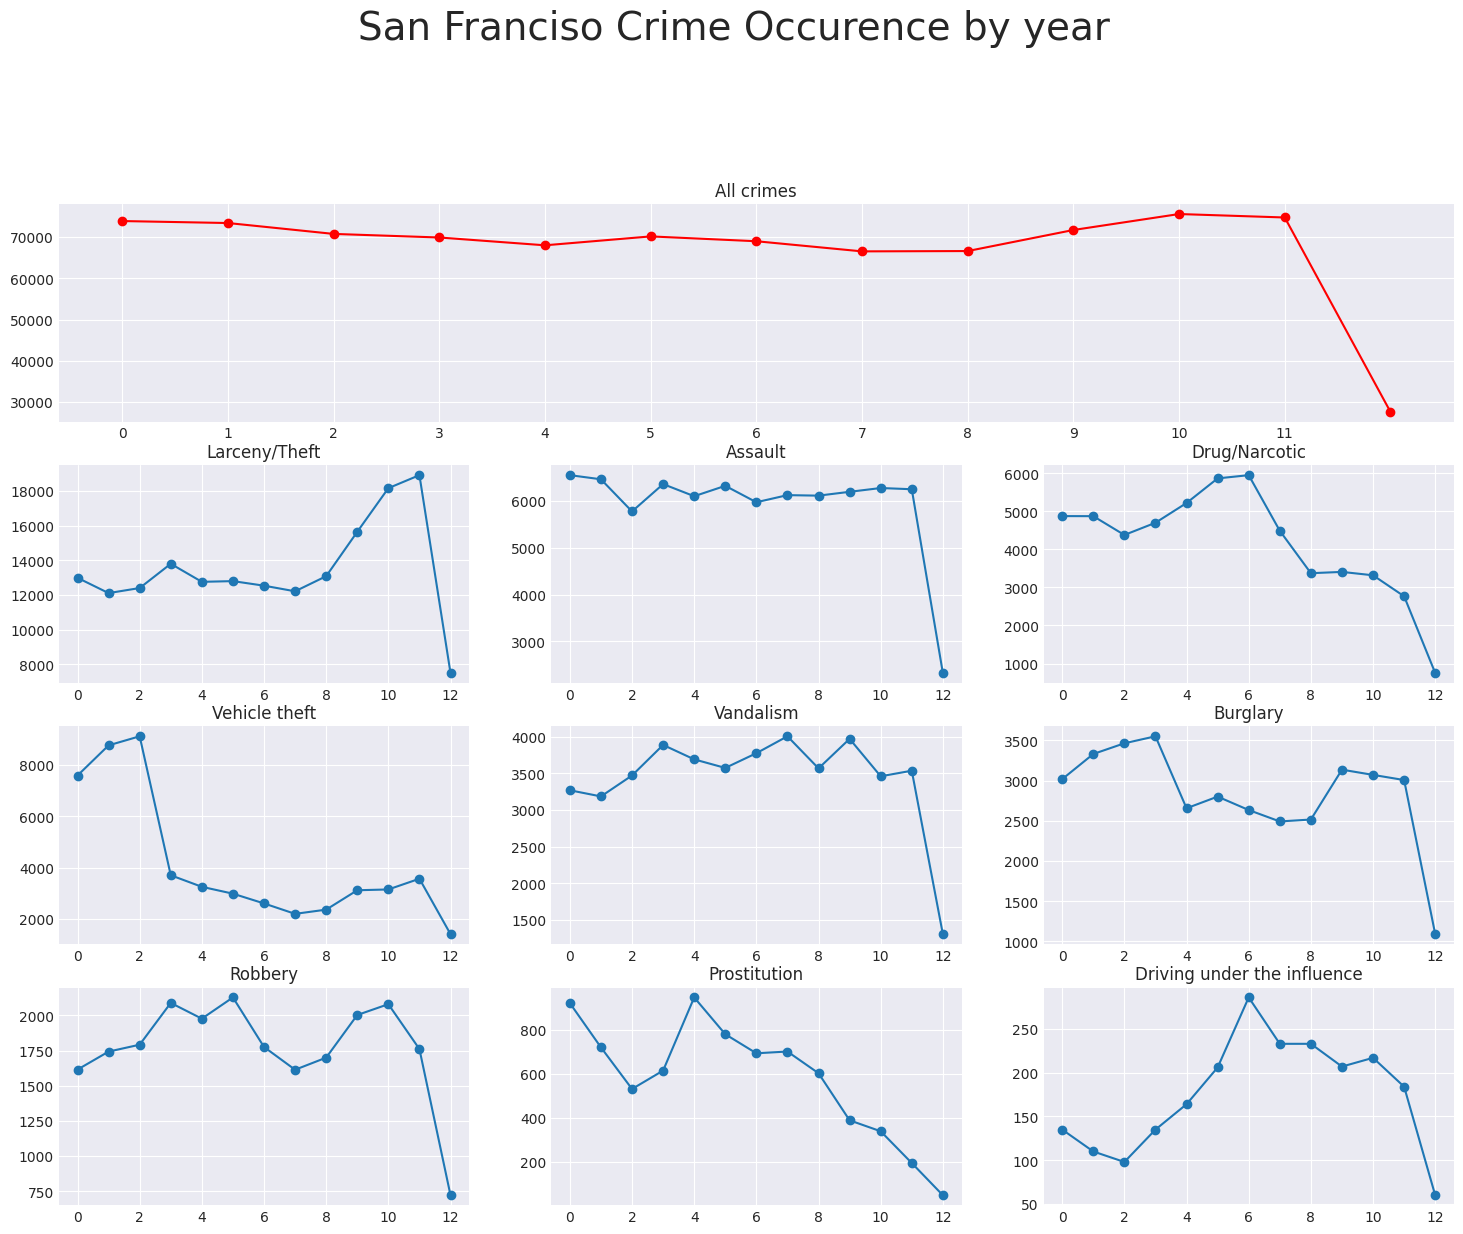

In [ ]:
pylab.rcParams['figure.figsize'] = (18.0, 13.0)

cats = [2000+i for i in range(3,16)]


with plt.style.context('seaborn-darkgrid'):
    ax1 = plt.subplot2grid((4,3), (0, 0), colspan=3)
    df = df_train.groupby('year').agg(count('category')).toPandas()
    df['year'] = pd.Categorical(df['year'], categories=cats, ordered=True)
    df = df.sort_values('year')
    df = df.reset_index()
    


    ax1.plot(df['count(category)'], 'ro-')
    ax1.set_title ('All crimes')
    ax1.xaxis.set_ticks(np.arange(0, 12, 1))
    
    ax2 = plt.subplot2grid((4,3), (1, 0))
    df1 = larceny.groupby('year').agg(count('category')).toPandas()
    df1['year'] = pd.Categorical(df1['year'], categories=cats, ordered=True)
    df1 = df1.sort_values('year')
    df1 = df1.reset_index().sort_values('year')
    ax2.plot(df1['count(category)'], 'o-')
    ax2.set_title ('Larceny/Theft')
    
    ax3 = plt.subplot2grid((4,3), (1, 1))
    df = assault.groupby('year').agg(count('category')).toPandas()
    df['year'] = pd.Categorical(df['year'], categories=cats, ordered=True)
    df = df.sort_values('year')
    df = df.reset_index()
    ax3.plot(df['count(category)'], 'o-')
    ax3.set_title ('Assault')
    
    ax4 = plt.subplot2grid((4,3), (1, 2))
    df = drug.groupby('year').agg(count('category')).toPandas()
    df['year'] = pd.Categorical(df['year'], categories=cats, ordered=True)
    df = df.sort_values('year')
    df = df.reset_index()
    ax4.plot(df['count(category)'], 'o-')
    ax4.set_title ('Drug/Narcotic')
    
    ax5 = plt.subplot2grid((4,3), (2, 0))
    df = vehicle.groupby('year').agg(count('category')).toPandas()
    df['year'] = pd.Categorical(df['year'], categories=cats, ordered=True)
    df = df.sort_values('year')
    df = df.reset_index()    
    ax5.plot(df['count(category)'], 'o-')
    ax5.set_title ('Vehicle theft')
    
    ax6 = plt.subplot2grid((4,3), (2, 1))
    df = vandalism.groupby('year').agg(count('category')).toPandas()
    df['year'] = pd.Categorical(df['year'], categories=cats, ordered=True)
    df = df.sort_values('year')
    df = df.reset_index()     
    ax6.plot(df['count(category)'], 'o-')
    ax6.set_title ('Vandalism')
    
    ax7 = plt.subplot2grid((4,3), (2, 2))
    df = burglary.groupby('year').agg(count('category')).toPandas()
    df['year'] = pd.Categorical(df['year'], categories=cats, ordered=True)
    df = df.sort_values('year')
    df = df.reset_index()    
    ax7.plot(df['count(category)'], 'o-')
    ax7.set_title ('Burglary')

    ax8 = plt.subplot2grid((4,3), (3, 0))
    df = robbery.groupby('year').agg(count('category')).toPandas()
    df['year'] = pd.Categorical(df['year'], categories=cats, ordered=True)
    df = df.sort_values('year')
    df = df.reset_index()    
    ax8.plot(df['count(category)'], 'o-')
    ax8.set_title ('Robbery')
    
    ax9 = plt.subplot2grid((4,3), (3, 1))
    df = prostitution.groupby('year').agg(count('category')).toPandas()
    df['year'] = pd.Categorical(df['year'], categories=cats, ordered=True)
    df = df.sort_values('year')
    df = df.reset_index()    
    ax9.plot(df['count(category)'], 'o-')
    ax9.set_title ('Prostitution')
    
    ax10 = plt.subplot2grid((4,3), (3, 2))
    df = driving_drunk.groupby('year').agg(count('category')).toPandas()
    df['year'] = pd.Categorical(df['year'], categories=cats, ordered=True)
    df = df.sort_values('year')
    df = df.reset_index()
    ax10.plot(df['count(category)'], 'o-')
    ax10.set_title ('Driving under the influence')
  
    pylab.gcf().text(0.5, 1.03, 
                    'San Franciso Crime Occurence by year',
                     horizontalalignment='center',
                     verticalalignment='top', 
                     fontsize = 28)
plt.show()

### Vector Assembler and Train/Test split

In [ ]:
# Data Assembly
train_set = train_set.withColumnRenamed('features','f')
assembler = VectorAssembler(inputCols=['month','year','dayofweek',\
                                       'pddistrict','f','resolution'
                                      ],\
                            outputCol='features')
train_set = assembler.transform(train_set)


In [ ]:
# set seed for reproducibility
(trainingData, testData) = train_set.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 614485
Test Dataset Count: 263564


### Support function for evaluation of results
The metric on which I based my evaluation is F1_macro.Precision and recall are also shown. 

In [ ]:
def evaluation_custom(results):
    # Input: prediction results
    # Output: f1, precision and recall score of postive class + AUC-PR
    predictionAndLabels = results.select(['prediction', 'label']).withColumn('label',col('label').cast(DoubleType())).rdd

    metrics = MulticlassMetrics(predictionAndLabels)
    print("Precision:", metrics.precision(1))
    print("Recall:", metrics.recall(1))
    f1_macro = (2*(metrics.recall(1) * metrics.precision(1)) / (metrics.recall(1) + metrics.precision(1)) + 2*(metrics.recall(0) * metrics.precision(0)) / (metrics.recall(0) + metrics.precision(0)))/2
    print("F1 macro:", f1_macro)
   

## Models
I used every multi class model available in pyspark documentation. In particular I used:
- Logistic regression using Count Vector Features
- Logistic regression using TF-IDF Features
- Naive Bayes
- Random Forest

Then I applied cross validation on the best scoring model in order to tune the parameters and improve the results.

### Logistic Regression using Count Vector Features
**Logistic regression** is one of the most popular Machine Learning algorithms, which comes under the **Supervised** Learning technique. It is used for predicting the categorical dependent variable using a given set of independent variables. It predicts the output of a categorical dependent variable. Therefore the outcome must be a categorical or discrete value, but instead of giving the exact value as 0 and 1, it gives the probabilistic values which lie between 0 and 1.
**Count vectorization** is the simplest approach to vectorization of 'string' features. CountVectorizer simply counts the number of times a word appears in a document (using a bag-of-words approach)

In [ ]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("Descript","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-------------+------------------------------+-----+----------+
|                      Descript|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8732956592069576,0.02013...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8732956592069576,0.02013...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8732956592069576,0.02013...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8732956592069576,0.02013...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8732956592069576,0.02013...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8732956592069576,0.02013...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8732956592069576,0.02013...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8

In [ ]:
# Evaluation

evaluation_custom(predictions)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision: 0.9498284197079377
Recall: 0.9999208923344672
F1 macro: 0.9831883288932888


### Logistic regression using TF-IDF features
**TF-IDF** Vectorizer takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus.

In [ ]:
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) 
#minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx, days_stringIdx, res_stringIdx, district_stringIdx])
pipelineFit = pipeline.fit(df_train)
dataset = pipelineFit.transform(df_train)
(trainingData1, testData1) = dataset.randomSplit([0.7, 0.3], seed = 100)

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData1)
predictions = lrModel.transform(testData1)
predictions.filter(predictions['prediction'] == 0) \
    .select("Descript","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-------------+------------------------------+-----+----------+
|                      Descript|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.886475931446247,0.018504...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.886475931446247,0.018504...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.886475931446247,0.018504...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.886475931446247,0.018504...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.886475931446247,0.018504...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.886475931446247,0.018504...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.886475931446247,0.018504...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8

In [ ]:
evaluation_custom(predictions)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision: 0.9455853958223627
Recall: 0.9999204497242257
F1 macro: 0.9829538966663471


### Naive Bayes
**Naive Bayes** is a popular and efficient machine learning model that utilizes the principles of **Bayesian probability** to make predictions and classifications. It is considered "naive" because it makes a strong **assumption of independence** among the features or variables in the dataset.
The model calculates the probability of a certain outcome given a set of input features by combining prior knowledge with observed evidence. It builds a probabilistic model based on the training data, learning the conditional probabilities of each feature given the class labels. During prediction, Naive Bayes calculates the posterior probability of each class label given the input features using Bayes' theorem and selects the label with the highest probability.

In [ ]:
nb = NaiveBayes(smoothing=1)
nbModel = nb.fit(trainingData)
nbPredictions = nbModel.transform(testData)


In [ ]:
#evaluation

evaluation_custom(nbPredictions)

Precision: 0.9991676288161534
Recall: 0.9867416207042851
F1 macro: 0.9960393134341441


#### Cross Validation
I am using cross validation in order to tune hyperparameters for best scoring model, in this case **Naive Bayes**. 
I use **Cross Validator** in order to find the best model and parameters. I use a **5-fold** cross validator which generates 5 sets of training/testing pairs.  To evaluate a particular model/param selection, CrossValidator computes the average evaluation metrics for the 5 models fitted on the 5 train/test pairs. 
 

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
nb = NaiveBayes()
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
              .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) 
             .build())# Create 5-fold CrossValidator

nbevaluator = MulticlassClassificationEvaluator()
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=nbevaluator, \
                    numFolds=5)
cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)

In [ ]:
# Evaluate best model
evaluation_custom(predictions)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision: 0.9500831527490803
Recall: 0.99981438268986
F1 macro: 0.982942695374095


### Random Forest
**Random Forest** is a powerful machine learning model that combines the strengths of **multiple decision trees** to make accurate predictions and classifications. It belongs to the ensemble learning category, which means it creates an **ensemble** of decision trees and combines their results to produce a final prediction.
The model works by constructing a multitude of decision trees, each trained on a **random subset of the training data** and using a random subset of the features. This randomness introduces diversity and helps **prevent overfitting**, where the model becomes too specialized to the training data and performs poorly on new data.

During prediction, each decision tree in the Random Forest independently classifies the input data, and the final prediction is determined by majority voting or averaging the predictions of all the individual trees. This ensemble approach makes Random Forest robust and less prone to errors caused by individual trees.

In [ ]:
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

# Train model with Training Data

rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("Descript","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+----------------------------+-------------+------------------------------+-----+----------+
|                    Descript|     Category|                   probability|label|prediction|
+----------------------------+-------------+------------------------------+-----+----------+
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.6292928064288287,0.06109...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.6292928064288287,0.06109...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.6292928064288287,0.06109...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.6292928064288287,0.06109...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.6292928064288287,0.06109...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.6292928064288287,0.06109...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.6292928064288287,0.06109...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.6292928064288287,0.0610

In [ ]:
# evaluation
evaluation_custom(predictions)

Precision: 0.37823142900135426
Recall: 0.9997878659312686
F1 macro: 0.7453064529632818


###Error Analysis
Here I am taking the results obtained from the best model (Naive Bayes), then a **multi class confusion matrix** is built upon this results. As we can see, since the model gives pretty strong results, there are not many misclassifications.Although we can see that 'suicide' is usually confused with 'family offenses', which is then confused with 'robbery'. Another misclassficiation which can be verified is the one between 'vehicle recovered' and 'drunkness'.

In [ ]:
def show_confusion_matrix(predictions):
  # collect pred and labels
  pl = predictions.select(['prediction', 'label']) 
  # build confusion matrix
  metrics = MulticlassMetrics(pl.rdd.map(tuple))
  cm = metrics.confusionMatrix().toArray()
  # collect label names
  label_names = df_train.groupby('category').count().toPandas()['category'].unique()
  # display matrix
  df_cm = pd.DataFrame(cm, index = label_names, columns = label_names)
  sns.set(font_scale=0.1) # for label size
  sns.set(rc={'figure.figsize':(15,10)})
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 5}) # font size
  plt.show()


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


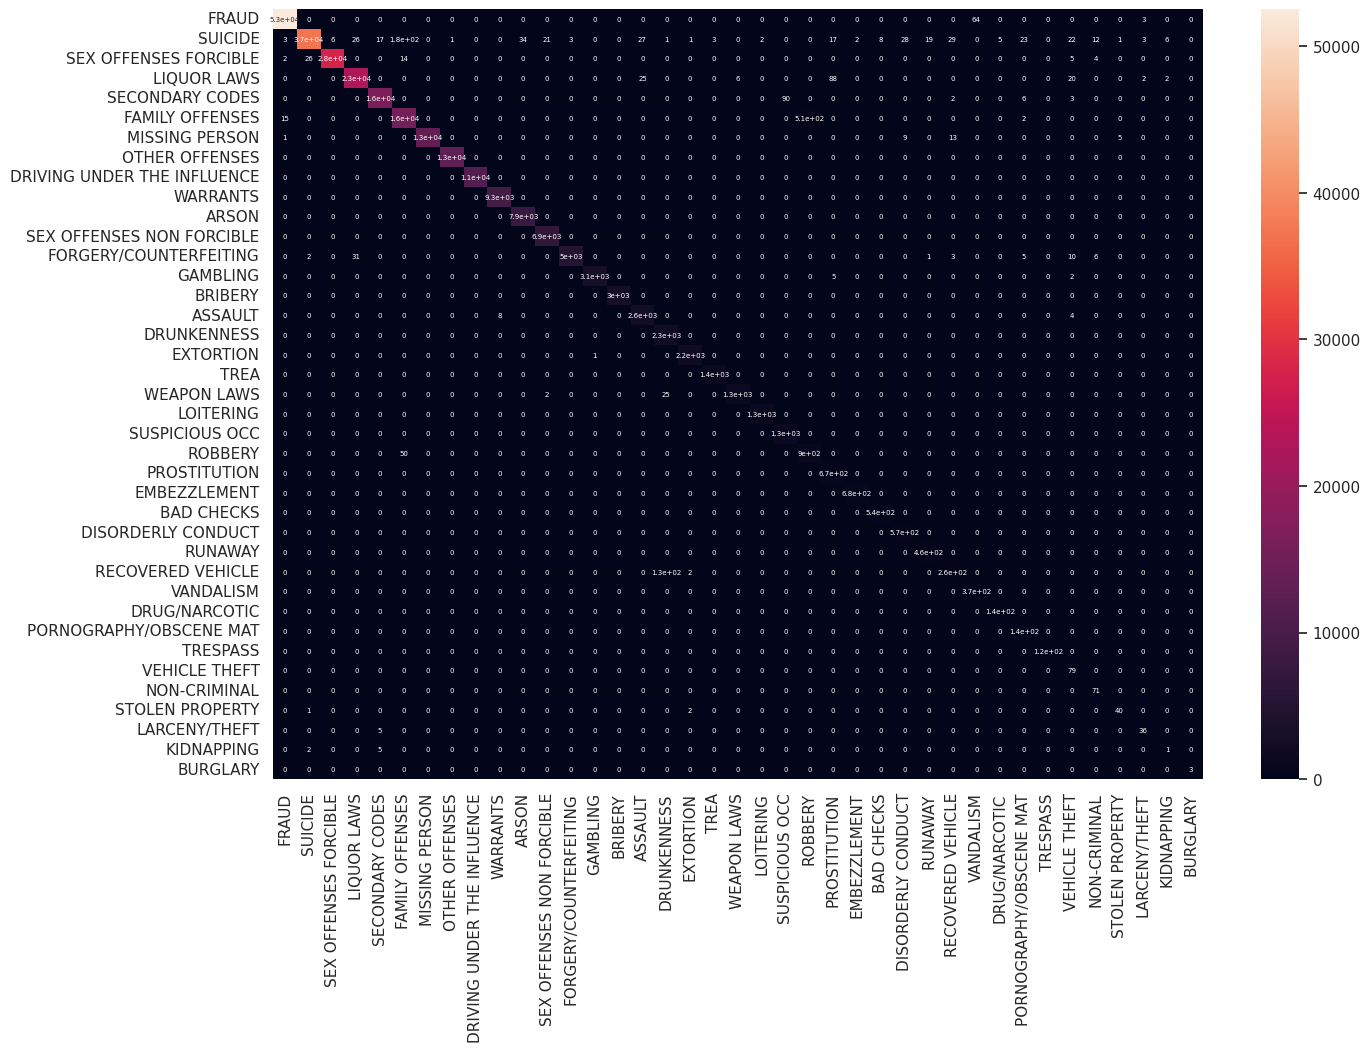

In [ ]:
show_confusion_matrix(nbPredictions)